# WildFire ML Project - Model Performance Evaluation

### Import modules

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as Data
from tqdm import tqdm
from sklearn import metrics
import torch
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

### Parameters Setup

In [3]:
batch_size = 20000 # 20000
split_ratio = 0.8
model_param_path = "WildFire CNN Prediction.pth"
source_data_path = "modeling_cnn_data.csv"
region_dict_path = "Z:/Programing_Space/DataSpell_Workspace/Research_Lawrence_Wildfire/1_source_data/region_segmentation.json"

## A. Data Preparation

### Load Dataset

In [4]:
# import dataset
dataset = pd.read_csv(source_data_path)
# get x and y
x_indic = dataset[["lat","lon","month","sequence"]]

x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x_indic = np.array(x_indic)
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

(106863, 16) (106863, 1)


### Normalization

In [5]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

### Train Test Split

In [6]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

### Dataloader

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs).float()
        self.label = torch.tensor(data_targets).float()

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [8]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [9]:
for i,(v,j) in enumerate(TrainDataLoader):
    print(v.shape,j.shape)
    break

torch.Size([20000, 16]) torch.Size([20000, 1])


### Model Architecture

In [10]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer5(x)

        return x

In [11]:
net = network().to(device)
net

network(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.15, inplace=False)
)

### Load pre-trained model

In [12]:
state_dict = torch.load(model_param_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

### Generate model predictions

In [13]:
# prepare data
val_x = torch.tensor(x_stand).float()
val_y = torch.tensor(y_stand).float()
lat_indicator = x_indic[:,0]
lon_indicator = x_indic[:,1]
month_indicator = x_indic[:,2]
year_indicator = x_indic[:,3]

# lat_indicator = x_indic[int(split_ratio*len(x_indic)):x.shape[0],0]
# lon_indicator = x_indic[int(split_ratio*len(x_indic)):x.shape[0],1]
# month_indicator = x_indic[int(split_ratio*len(x_indic)):x.shape[0],2]
# year_indicator = x_indic[int(split_ratio*len(x_indic)):x.shape[0],3]

# create lists
month_list = []
y_true_list = []
y_pred_list = []
region_list = []
year_list = []

# validation mode
net.eval()
for idx in tqdm(range(val_x.shape[0])):
    month_list.append(month_indicator[idx])
    region_list.append([lat_indicator[idx],lon_indicator[idx]])
    year_list.append(year_indicator[idx])
    x_input = val_x[idx,:].to(device)
    y_input = val_y[idx,-1].to(device).detach().cpu().numpy().squeeze()
    y_true_list.append(y_input)
    y_pred = net(x_input)
    y_pred = y_pred.detach().cpu().numpy().squeeze()
    y_pred_list.append(y_pred)

100%|██████████| 106863/106863 [01:29<00:00, 1197.75it/s]


## B. Performance Evaluation

### Evaluation Panel Preparation

In [14]:
# Import JSON file
with open(region_dict_path,'r', encoding='UTF-8') as f:
    region_dict = json.load(f)

In [15]:
# Lambda Function to substitute Lat and Lon with Region names
def region_labeler(x):
    for region_name in region_dict.keys():
        if x in region_dict[region_name]:
            return region_name

# month_dict_convertor
month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
# Lambda Function to substitute years seq to years 
year_dict_temp = list(set(year_list))
year_dict= {}
sep_lst = []
start_year = 2001
for i,v in enumerate(year_dict_temp):
    if (i+1) % 12 != 0:
        sep_lst.append(v)
    else:
        sep_lst.append(v)
        year_dict[start_year] = sep_lst
        sep_lst = []
        start_year += 1
def year_labeler(x):
    for yrs in year_dict.keys():
        if x in year_dict[yrs]:
            return yrs

In [16]:
# Reverse Standization
true_log_value = scaler_y.inverse_transform(np.array(y_true_list).reshape(-1,1))
pred_log_value = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1,1))

evaluator = pd.DataFrame(columns=["y_true","y_pred","month","region","year"])
# model predictions
evaluator["y_true"] = y_true_list
evaluator["y_pred"] = y_pred_list
# inverse standardization
evaluator["y_true_transform_log"] = true_log_value
evaluator["y_pred_transform_log"] = pred_log_value

evaluator["y_true_transform_origin"] = np.exp(evaluator["y_true_transform_log"])
evaluator["y_pred_transform_origin"] = np.exp(evaluator["y_pred_transform_log"])
rela_factor = evaluator["y_true_transform_origin"].mean() / evaluator["y_pred_transform_origin"].mean()
evaluator["y_pred_transform_origin"] = evaluator["y_pred_transform_origin"] * rela_factor

# month labeling
evaluator["month"] = month_list
evaluator["month_label"] = evaluator["month"].apply(lambda x: month_dict[x])
# year labeling
evaluator["year"] = year_list
evaluator["year_label"] = evaluator["year"].apply(lambda x: year_labeler(x))
# region labeling
evaluator["region"] = region_list
evaluator["region_label"] = evaluator["region"].apply(lambda x: region_labeler(x))
# drop na values
evaluator.dropna(inplace=True)

### 1. Accuracy, Correlation Scores

In [17]:
print("-> Accuracy Score (R-sqaured): ", metrics.r2_score(y_true_list,y_pred_list))
print("-> Pearson Correlation Score (Rho): ", np.corrcoef(y_true_list,y_pred_list)[0][1])

-> Accuracy Score (R-sqaured):  0.7737686872657547
-> Pearson Correlation Score (Rho):  0.8811102161969723


### 2. Evaluation by Years

In [18]:
evaluation_year = evaluator.copy()
evaluation_year = evaluation_year[['y_true', 'y_pred','y_true_transform_log',
                                   'y_pred_transform_log', 'y_true_transform_origin',
                                   'y_pred_transform_origin', 'year_label']]
group_data = pd.DataFrame(evaluation_year.groupby(by="year_label").sum())

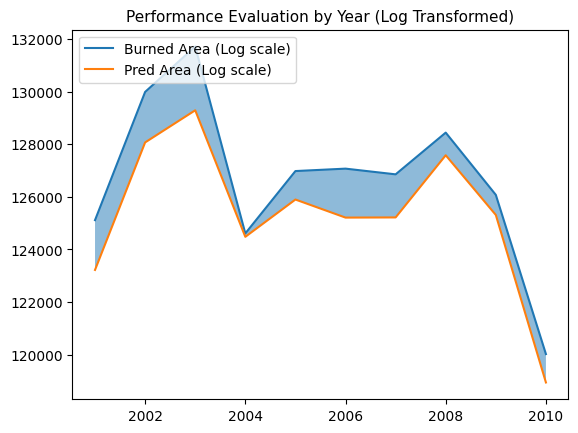

In [19]:
plt.plot(group_data["y_true_transform_log"], label = "Burned Area (Log scale)")
plt.plot(group_data["y_pred_transform_log"], label = "Pred Area (Log scale)")
plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(), group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
plt.title("Performance Evaluation by Year (Log Transformed)",fontsize = 11)
plt.legend(loc = "upper left",fontsize = 10)
plt.show()

### 3. Evaluation by Months

In [20]:
evaluation_month = evaluator.copy()
del evaluation_month["region"]
group_data = pd.DataFrame(evaluation_month.groupby(by="month").sum()).sort_values(by="month")
group_data["month_label"] = group_data.index
group_data["month_label"] = group_data["month_label"].apply(lambda x: month_dict[x])
group_data.set_index("month_label",inplace=True,drop=True)

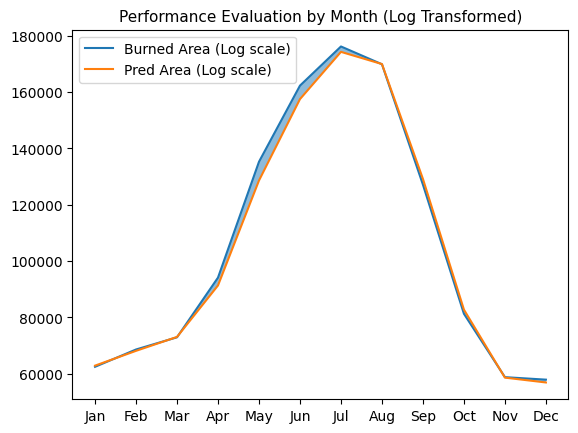

In [21]:
plt.plot(group_data["y_true_transform_log"], label = "Burned Area (Log scale)")
plt.plot(group_data["y_pred_transform_log"], label = "Pred Area (Log scale)")
plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(), group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
plt.title("Performance Evaluation by Month (Log Transformed)",fontsize = 11)
plt.legend(loc = "upper left",fontsize = 10)
plt.show()

### 4. Evaluation By Region & Year

In [22]:
evaluation_region = evaluator.copy()
group_data = pd.DataFrame(evaluation_region.groupby(by=["year","region_label"]).sum())
group_data["region"] = group_data.index
group_data["region"] = group_data["region"].apply(lambda x: x[1])
region_num_mapper = {}
for i,v in enumerate(set(group_data["region"].tolist())):
    region_num_mapper[v] = i
group_data["region_label"] = group_data["region"].apply(lambda x: region_num_mapper[x])

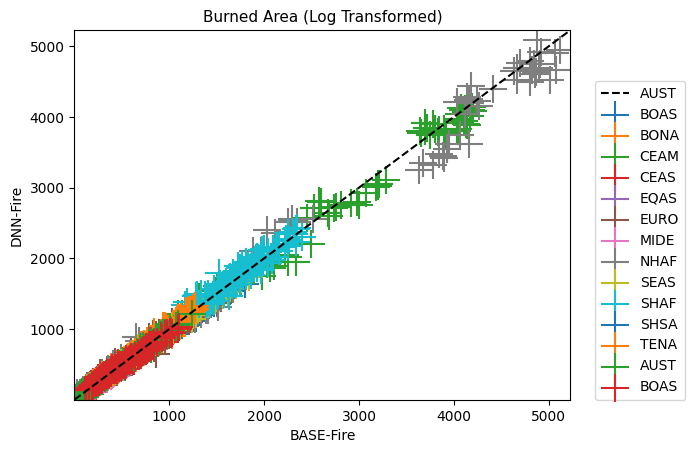

In [23]:
x_line = np.linspace(group_data["y_pred_transform_log"].min()-12, group_data["y_pred_transform_log"].max(), 100)
y_line = x_line
plt.plot(x_line, y_line, 'r--',c="k")
# Iterations to draw scatter points
region_list = region_num_mapper.keys()
for i, reg in enumerate(region_list):
    temp_df = group_data.loc[group_data["region"] == reg]
    plt.scatter(temp_df["y_true_transform_log"],temp_df["y_pred_transform_log"], marker="+",s=400)
plt.xlim(np.min(x_line), np.max(x_line))
plt.ylim(np.min(y_line), np.max(y_line))
plt.title("Burned Area (Log Transformed)",fontsize = 11)
plt.xlabel("BASE-Fire")
plt.ylabel("DNN-Fire")
plt.legend(labels = group_data["region"], bbox_to_anchor=(1.05, 0), loc = 3, borderaxespad = 0)
plt.show()

### 5. Evaluation by Region

In [24]:
evaluation_region = evaluator.copy()
group_data = pd.DataFrame(evaluation_region.groupby(by=["region_label"]).sum())
group_data["region"] = group_data.index
group_data["region"] = group_data["region"].apply(lambda x: x[1])
region_num_mapper = {}
for i,v in enumerate(set(group_data["region"].tolist())):
    region_num_mapper[v] = i
group_data["region_label"] = group_data["region"].apply(lambda x: region_num_mapper[x])

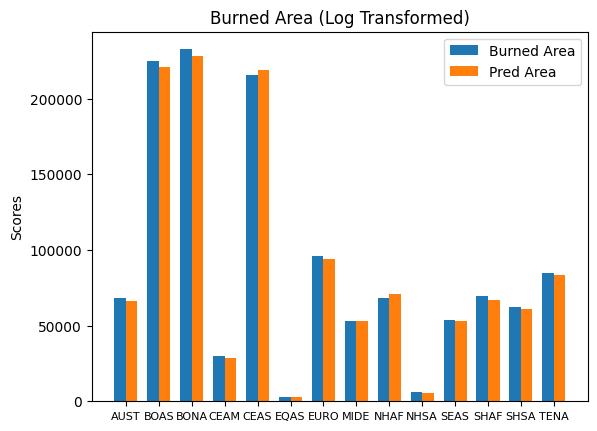

In [25]:
labels = group_data.index.tolist()
true_area = group_data["y_true_transform_log"].tolist()
pred_area = group_data["y_pred_transform_log"].tolist()
x = np.arange(len(group_data.index.tolist()))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true_area, width, label='Burned Area')
rects2 = ax.bar(x + width/2, pred_area, width, label='Pred Area')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Burned Area (Log Transformed)')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 8)
ax.legend()
plt.show()